In [53]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Inspect data
print(customers.head())
print(products.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [54]:
# Handle missing values
customers.dropna(inplace=True)
products.dropna(inplace=True)
transactions.dropna(inplace=True)

# Convert data types
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

                SignupDate
count                  200
mean   2023-07-19 08:31:12
min    2022-01-22 00:00:00
25%    2022-09-26 12:00:00
50%    2023-08-31 12:00:00
75%    2024-04-12 12:00:00
max    2024-12-28 00:00:00
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
                     TransactionDate     Quantity   TotalValue       Price
count                           1000  1000.000000  1000.000000  1000.00000
mean   2024-06-23 15:33:02.768999936     2.537000   689.995560   272.55407
min              2023-12-30 15:29:12     1.000000    16.080000    16.08000
25%       2024-03-25 22:05:34.500000     2.000000   295.295000   147.95000
50%       2024-06-26 17:21:52.500000     3.000000   588.880000   299.93000
75%              2024-09-19 14:19:57     4.000000  1011.660000   404.40000
max              2024-12-28 11:00:00     4.000000  1991.040000   497.76000
std                   

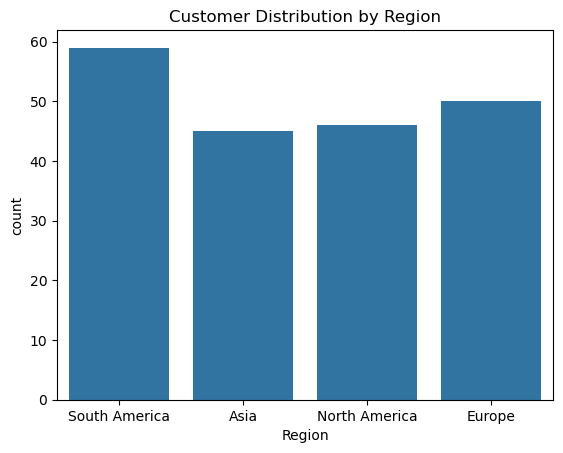

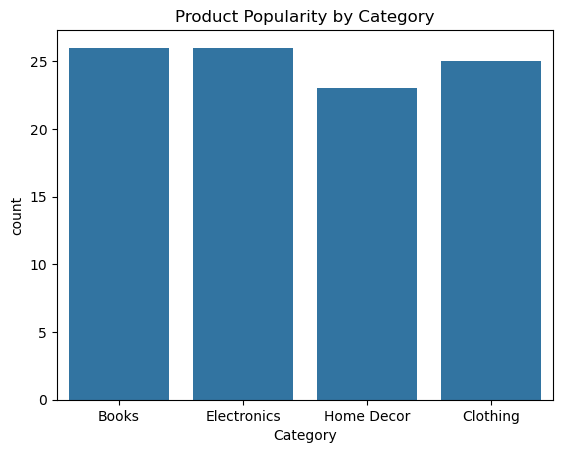

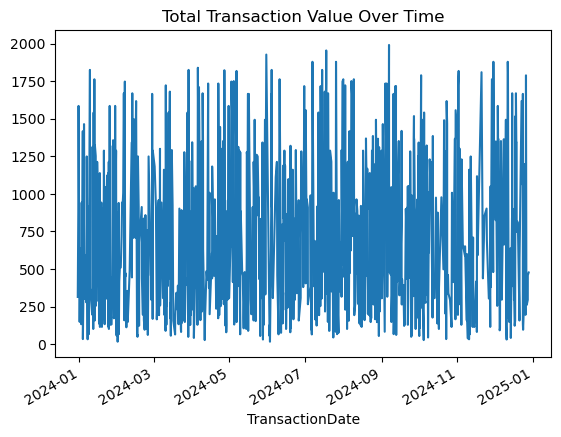

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive statistics
print(customers.describe())
print(products.describe())
print(transactions.describe())

# Visualizations
# Distribution of customer regions
sns.countplot(x='Region', data=customers)
plt.title('Customer Distribution by Region')
plt.show()

# Product category popularity
sns.countplot(x='Category', data=products)
plt.title('Product Popularity by Category')
plt.show()

# Transaction value over time
transactions.groupby('TransactionDate')['TotalValue'].sum().plot()
plt.title('Total Transaction Value Over Time')
plt.show()


In [56]:
# Aggregate transaction data to get customer profiles
customer_profiles = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'
}).reset_index()

customer_profiles.columns = ['CustomerID', 'TotalSpent', 'TotalQuantity', 'TransactionCount']

# Merge with customer data
customer_profiles = pd.merge(customer_profiles, customers, on='CustomerID')

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
customer_features = scaler.fit_transform(customer_profiles[['TotalSpent', 'TotalQuantity', 'TransactionCount']])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(customer_features)

In [58]:
# Function to get top 3 similar customers
def get_top_similar_customers(customer_id, n=3):
    customer_index = customer_profiles[customer_profiles['CustomerID'] == customer_id].index[0]
    similarity_scores = list(enumerate(similarity_matrix[customer_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_similar_customers = [customer_profiles.iloc[i[0]]['CustomerID'] for i in similarity_scores[1:n+1]]
    top_scores = [i[1] for i in similarity_scores[1:n+1]]
    return list(zip(top_similar_customers, top_scores))

# Generate recommendations for the first 20 customers
lookalike_recommendations = {}
for customer_id in customers['CustomerID'][:20]:
    lookalike_recommendations[customer_id] = get_top_similar_customers(customer_id)

# Save recommendations to CSV
import csv

with open('Lookalike.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['CustomerID', 'Lookalikes'])
    for customer_id, lookalikes in lookalike_recommendations.items():
        writer.writerow([customer_id, lookalikes])